In [1]:
import os
import gc
import joblib
import numpy as np
import pandas as pd
import mlflow
import shap
import catboost as cat
import xgboost as xgb
import featuretools as ft
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from typing import Tuple, Callable
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder 
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working


In [2]:
pd.set_option('use_inf_as_na', True)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [3]:
# Features
PASSENGER_ID  = 'PassengerId'
SURVIVED = 'Survived'
PCLASS = 'Pclass'
NAME = 'Name'
SEX = 'Sex'
AGE = 'Age'
SIBSP = 'SibSp'
PARCH = 'Parch'
TICKET = 'Ticket'
FARE = 'Fare'
CABIN = 'Cabin'
EMBARKED = 'Embarked'
CAT_FEATURES = [PCLASS, SEX, TICKET, CABIN, EMBARKED]
TRANS_PRIMITIVES = ['multiply_numeric', 'divide_numeric']

DEFAULT_OTHER_NAME = 'Other'
DEFAULT_NAN_NAME = 'NaN'
DEFAULT_OTHER_FOR_NUMERIC = -99999
DEFAULT_NAN_FOR_NUMERIC = -88888
TRAIN_FILE = "data/train.csv"
TEST_FILE = "data/test.csv"
REPORT_PATH = 'reports/titanic_report.html'

In [4]:
train = pd.read_csv(TRAIN_FILE)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
shap.initjs()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [8]:
if not os.path.exists(REPORT_PATH):
    report = ProfileReport(train, title='Titanic Report', explorative=True)
    report.to_file(REPORT_PATH)

# Drop features

In [9]:
train.drop(columns=[PASSENGER_ID, NAME], inplace=True)

In [10]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


# Functions for filling NaNs and categorical values

In [11]:
def fill_numeric(dataset: pd.DataFrame, column_name: str):
    dataset[column_name].fillna(dataset[column_name].median(), inplace=True)
    
# with Label Encoder    
def fill_categorical_label(dataset: pd.DataFrame, column_name: str, fillna=True):
    if fillna:
        dataset[column_name].fillna(value=DEFAULT_NAN_NAME, inplace=True)
    label_encoder = LabelEncoder().fit(np.sort(dataset[column_name].unique()))
    dataset[column_name] = dataset[column_name].map(
        dict(zip(dataset[column_name].unique(), label_encoder.transform(dataset[column_name].unique()))))
    return label_encoder

#Target Encoder
def fill_categorical_target(dataset: pd.DataFrame, column_name: str, target_column: str, fillna=True):
    if fillna:
        dataset[column_name].fillna(value=DEFAULT_NAN_NAME, inplace=True)
    target_encoder = TargetEncoder()
    dataset[column_name] = target_encoder.fit_transform(dataset[column_name], dataset[target_column])
    return target_encoder

#OneHot Encoder
def fill_categorical_onehot(dataset: pd.DataFrame, column_name: str, fillna=True):
    if fillna:
        dataset[column_name].fillna(value=DEFAULT_NAN_NAME, inplace=True)
    le = LabelEncoder()
    dataset[column_name + "Encoded"] = le.fit_transform(dataset[column_name])
    encoder = OneHotEncoder(categories = 'auto')
    X = encoder.fit_transform(dataset[column_name + "Encoded"].values.reshape(-1,1)).toarray()
    dfonehot = pd.DataFrame(X)
    df = pd.concat([dataset, dfonehot], axis = 1)
    new_cols = list(dataset.columns)
    unique = sorted(dataset[column_name].unique())
    new_cols.extend(["is" + str(value) for value in unique])
    df.columns = new_cols
    print(new_cols)
    return df
    
    

    
    
    

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [12]:
encoded_df = train.copy()

In [13]:
df = fill_categorical_onehot(encoded_df, SEX)

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexEncoded', 'isfemale', 'ismale']


In [14]:
df.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEncoded,isfemale,ismale
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0.0,1.0
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,1.0,0.0
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1.0,0.0
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,0,1.0,0.0
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,0.0,1.0


# Creating datasets with different label encoders

In [15]:
# label encoding
label_encoded_train = train.copy()
for cat_feature in CAT_FEATURES:
    fill_categorical_label(label_encoded_train, cat_feature)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [16]:
label_encoded_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,2,1,22.0,1,0,523,7.2500,146,3
1,1,0,0,38.0,1,0,596,71.2833,81,0
2,1,2,0,26.0,0,0,669,7.9250,146,3
3,1,0,0,35.0,1,0,49,53.1000,55,3
4,0,2,1,35.0,0,0,472,8.0500,146,3


In [17]:
# target encoding
target_encoded_train = train.copy()
for cat_feature in CAT_FEATURES:
    fill_categorical_target(target_encoded_train, cat_feature, SURVIVED)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [18]:
target_encoded_train.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,0.188908,22.0,1,0,0.383838,7.2500,0.299854,0.336957
1,1,1,0.742038,38.0,1,0,0.383838,71.2833,0.383838,0.553571
2,1,3,0.742038,26.0,0,0,0.383838,7.9250,0.299854,0.336957
3,1,1,0.742038,35.0,1,0,0.468759,53.1000,0.468759,0.336957
4,0,3,0.188908,35.0,0,0,0.383838,8.0500,0.299854,0.336957


In [19]:
# onehot encoding
onehot_encoded_train = train.copy()
for cat_feature in CAT_FEATURES:
    onehot_encoded_train = fill_categorical_onehot(onehot_encoded_train, cat_feature)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'PclassEncoded', 'is1', 'is2', 'is3']
['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'PclassEncoded', 'is1', 'is2', 'is3', 'SexEncoded', 'isfemale', 'ismale']
['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'PclassEncoded', 'is1', 'is2', 'is3', 'SexEncoded', 'isfemale', 'ismale', 'TicketEncoded', 'is110152', 'is110413', 'is110465', 'is110564', 'is110813', 'is111240', 'is111320', 'is111361', 'is111369', 'is111426', 'is111427', 'is111428', 'is112050', 'is112052', 'is112053', 'is112058', 'is112059', 'is112277', 'is112379', 'is113028', 'is113043', 'is113050', 'is113051', 'is113055', 'is113056', 'is113059', 'is113501', 'is113503', 'is113505', 'is113509', 'is113510', 'is113514', 'is113572', 'is113760', 'is113767', 'is113773', 'is113776', 'is113781', 'is113783', 'is113784', 'is113786', 'is113787', 'is113788',

In [20]:
len(onehot_encoded_train.columns)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


853

In [21]:
onehot_encoded_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,isF38,isF4,isG6,isNaN,isT,EmbarkedEncoded,isC,isNaN,isQ,isS
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,...,0.0,0.0,0.0,1.0,0.0,3,0.0,0.0,0.0,1.0
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,...,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,0.0,0.0,0.0,1.0,0.0,3,0.0,0.0,0.0,1.0
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,...,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,1.0
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,...,0.0,0.0,0.0,1.0,0.0,3,0.0,0.0,0.0,1.0


In [22]:
onehot_encoded_train.drop(CAT_FEATURES, axis=1, inplace=True)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [23]:
onehot_encoded_train.head()

,Survived,Age,SibSp,Parch,Fare,PclassEncoded,is1,is2,is3,SexEncoded,...,isF38,isF4,isG6,isNaN,isT,EmbarkedEncoded,isC,isNaN,isQ,isS
0,0,22.0,1,0,7.2500,2,0.0,0.0,1.0,1,...,0.0,0.0,0.0,1.0,0.0,3,0.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,0,1.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0
2,1,26.0,0,0,7.9250,2,0.0,0.0,1.0,0,...,0.0,0.0,0.0,1.0,0.0,3,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0,1.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,1.0
4,0,35.0,0,0,8.0500,2,0.0,0.0,1.0,1,...,0.0,0.0,0.0,1.0,0.0,3,0.0,0.0,0.0,1.0


# Learn Random Forest Classifier

In [24]:
# making train and test sets
label_encoded_train.drop(SURVIVED, axis=1, inplace=True)
target_encoded_train.drop(SURVIVED, axis=1, inplace=True)
onehot_encoded_train.drop(SURVIVED, axis=1, inplace=True)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [25]:
# target
y_train = train[SURVIVED]

In [26]:
# filling age NaNs
fill_numeric(label_encoded_train, AGE)
fill_numeric(target_encoded_train, AGE)
fill_numeric(onehot_encoded_train, AGE)

In [27]:
# label encoded train
label_train, label_test, label_y_train, label_y_test = train_test_split(label_encoded_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [28]:
# target encoded train
target_train, target_test, target_y_train, target_y_test = train_test_split(target_encoded_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [29]:
# onehot encoded sets
onehot_encoded_train.Age.fillna(onehot_encoded_train.Age.median(), inplace=True)
onehot_train, onehot_test, onehot_y_train, onehot_y_test = train_test_split(onehot_encoded_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [30]:
onehot_encoded_train.Age

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

# Random Forest Classifier

In [31]:
rfc_params = {
    "n_estimators": 10,
    "criterion": "gini",
    "min_samples_split": 5,
    "max_features": "auto",
    "bootstrap": True,
    "n_jobs": -1
}


In [32]:
rfc = RandomForestClassifier(**rfc_params)

In [33]:
# label encoded data
rfc.fit(label_train, label_y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=10, n_jobs=-1)

In [34]:
print(classification_report(label_y_test, rfc.predict(label_test)))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       110
           1       0.75      0.62      0.68        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179



`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [35]:
accuracy_score(rfc.predict(label_test), label_y_test)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0.776536312849162

In [36]:
roc_auc_score(label_y_test, rfc.predict_proba(label_test)[:, 1])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0.8013175230566535

# XGBoost Classifier

In [37]:
xgb_params = {
    'random_state': 42,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'n_estimators': 1000,
    'eta': 0.02,
    'max_depth': 3,
    'min_child_weight': 1,
    'reg_lambda': 1,
    'max_bin': 120,
    'subsample': 0.9
}

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [38]:
xgbc = xgb.XGBClassifier(**xgb_params) 

In [39]:
xgbc.fit(label_train, label_y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:06:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.02, gamma=0,
              gpu_id=-1, grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.0199999996,
              max_bin=120, max_delta_step=0, max_depth=3, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, num_parallel_tree=1, random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [40]:
print(classification_report(label_y_test, xgbc.predict(label_test)))
print(accuracy_score(xgbc.predict(label_test), label_y_test))
print(roc_auc_score(label_y_test, xgbc.predict_proba(label_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.64      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

0.7988826815642458
0.8220026350461134


# CatBoost Classifier

In [41]:
cat_params = {
    'random_seed': 42,
    'iterations': 1000,
    'depth': 4,
    'learning_rate': 0.05,
    'l2_leaf_reg': 1,
    'border_count': 120,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20
}

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [42]:
catc = cat.CatBoostClassifier(**cat_params)

In [43]:
catc.fit(label_train, label_y_train)

0:	learn: 0.6740932	total: 88ms	remaining: 1m 27s
1:	learn: 0.6493538	total: 90.3ms	remaining: 45.1s
2:	learn: 0.6239898	total: 92.7ms	remaining: 30.8s
3:	learn: 0.5994483	total: 95ms	remaining: 23.7s
4:	learn: 0.5787029	total: 97.3ms	remaining: 19.4s
5:	learn: 0.5608809	total: 100ms	remaining: 16.6s
6:	learn: 0.5448986	total: 102ms	remaining: 14.5s
7:	learn: 0.5316898	total: 104ms	remaining: 12.9s
8:	learn: 0.5177832	total: 107ms	remaining: 11.7s
9:	learn: 0.5068532	total: 109ms	remaining: 10.8s
10:	learn: 0.4938967	total: 111ms	remaining: 9.98s
11:	learn: 0.4855200	total: 113ms	remaining: 9.33s
12:	learn: 0.4783158	total: 115ms	remaining: 8.77s
13:	learn: 0.4727569	total: 118ms	remaining: 8.28s
14:	learn: 0.4664778	total: 120ms	remaining: 7.87s
15:	learn: 0.4567992	total: 122ms	remaining: 7.48s
16:	learn: 0.4510409	total: 123ms	remaining: 7.14s
17:	learn: 0.4469665	total: 125ms	remaining: 6.84s
18:	learn: 0.4397350	total: 127ms	remaining: 6.57s
19:	learn: 0.4357798	total: 129ms	remai

237:	learn: 0.2270461	total: 270ms	remaining: 863ms
238:	learn: 0.2266493	total: 270ms	remaining: 861ms
239:	learn: 0.2262910	total: 271ms	remaining: 859ms
240:	learn: 0.2262448	total: 272ms	remaining: 856ms
241:	learn: 0.2259401	total: 273ms	remaining: 854ms
242:	learn: 0.2254055	total: 273ms	remaining: 852ms
243:	learn: 0.2249341	total: 274ms	remaining: 849ms
244:	learn: 0.2244157	total: 275ms	remaining: 847ms
245:	learn: 0.2239995	total: 275ms	remaining: 844ms
246:	learn: 0.2234665	total: 276ms	remaining: 842ms
247:	learn: 0.2231881	total: 277ms	remaining: 839ms
248:	learn: 0.2225575	total: 277ms	remaining: 837ms
249:	learn: 0.2221198	total: 278ms	remaining: 834ms
250:	learn: 0.2218199	total: 279ms	remaining: 832ms
251:	learn: 0.2212517	total: 279ms	remaining: 829ms
252:	learn: 0.2206485	total: 280ms	remaining: 827ms
253:	learn: 0.2201265	total: 281ms	remaining: 825ms
254:	learn: 0.2194687	total: 282ms	remaining: 823ms
255:	learn: 0.2188067	total: 282ms	remaining: 820ms
256:	learn: 

554:	learn: 0.1305565	total: 449ms	remaining: 360ms
555:	learn: 0.1303221	total: 450ms	remaining: 359ms
556:	learn: 0.1301302	total: 451ms	remaining: 358ms
557:	learn: 0.1299383	total: 454ms	remaining: 359ms
558:	learn: 0.1294899	total: 454ms	remaining: 358ms
559:	learn: 0.1291517	total: 455ms	remaining: 357ms
560:	learn: 0.1286170	total: 455ms	remaining: 356ms
561:	learn: 0.1284889	total: 456ms	remaining: 355ms
562:	learn: 0.1283291	total: 456ms	remaining: 354ms
563:	learn: 0.1280637	total: 457ms	remaining: 353ms
564:	learn: 0.1278468	total: 457ms	remaining: 352ms
565:	learn: 0.1276485	total: 458ms	remaining: 351ms
566:	learn: 0.1274934	total: 458ms	remaining: 350ms
567:	learn: 0.1273571	total: 459ms	remaining: 349ms
568:	learn: 0.1268972	total: 459ms	remaining: 348ms
569:	learn: 0.1266906	total: 460ms	remaining: 347ms
570:	learn: 0.1264766	total: 461ms	remaining: 346ms
571:	learn: 0.1262946	total: 462ms	remaining: 345ms
572:	learn: 0.1259112	total: 462ms	remaining: 344ms
573:	learn: 

855:	learn: 0.0828484	total: 627ms	remaining: 106ms
856:	learn: 0.0826748	total: 628ms	remaining: 105ms
857:	learn: 0.0825891	total: 629ms	remaining: 104ms
858:	learn: 0.0824514	total: 630ms	remaining: 103ms
859:	learn: 0.0823947	total: 631ms	remaining: 103ms
860:	learn: 0.0822996	total: 631ms	remaining: 102ms
861:	learn: 0.0822581	total: 632ms	remaining: 101ms
862:	learn: 0.0821781	total: 633ms	remaining: 100ms
863:	learn: 0.0820779	total: 633ms	remaining: 99.7ms
864:	learn: 0.0819160	total: 634ms	remaining: 98.9ms
865:	learn: 0.0818451	total: 634ms	remaining: 98.2ms
866:	learn: 0.0817601	total: 635ms	remaining: 97.4ms
867:	learn: 0.0815760	total: 635ms	remaining: 96.6ms
868:	learn: 0.0814429	total: 636ms	remaining: 95.8ms
869:	learn: 0.0813236	total: 636ms	remaining: 95.1ms
870:	learn: 0.0812360	total: 637ms	remaining: 94.3ms
871:	learn: 0.0811181	total: 637ms	remaining: 93.5ms
872:	learn: 0.0809268	total: 638ms	remaining: 92.8ms
873:	learn: 0.0808199	total: 638ms	remaining: 92ms
874

In [44]:
print(classification_report(label_y_test, catc.predict(label_test)))
print("Accuracy score", accuracy_score(catc.predict(label_test), label_y_test))
print("ROC AUC score", roc_auc_score(label_y_test, catc.predict_proba(label_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.71      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy score 0.8100558659217877
ROC AUC score 0.8218708827404481


# LightGBM Classifier

In [45]:
lgb_params = {
    "boosting_type": "gbdt",
    "random_state": 42,
    "n_jobs": -1,
    "n_estimators": 10
}

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [46]:
lgbc = LGBMClassifier(**lgb_params)

In [47]:
lgbc.fit(label_train, label_y_train)

LGBMClassifier(n_estimators=10, random_state=42)

In [48]:
print(classification_report(label_y_test, lgbc.predict(label_test)))
print("Accuracy score", accuracy_score(lgbc.predict(label_test), label_y_test))
print("ROC AUC score", roc_auc_score(label_y_test, lgbc.predict_proba(label_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       110
           1       0.73      0.54      0.62        69

    accuracy                           0.74       179
   macro avg       0.74      0.70      0.71       179
weighted avg       0.74      0.74      0.73       179

Accuracy score 0.7430167597765364
ROC AUC score 0.8169301712779974


# Learn SVC

In [49]:
svc_params = {
    "C": 11,
    "gamma": 0.002,
    "random_state": 42,
    "probability": True,
}

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [50]:
svc = SVC(**svc_params)

In [51]:
svc.fit(label_train, label_y_train)

SVC(C=11, gamma=0.002, probability=True, random_state=42)

In [52]:
print(classification_report(label_y_test, svc.predict(label_test)))
print("Accuracy score", accuracy_score(svc.predict(label_test), label_y_test))
print("ROC AUC score", roc_auc_score(label_y_test, svc.predict_proba(label_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       110
           1       0.61      0.43      0.51        69

    accuracy                           0.68       179
   macro avg       0.66      0.63      0.63       179
weighted avg       0.67      0.68      0.66       179

Accuracy score 0.6759776536312849
ROC AUC score 0.7118577075098813


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# kNN Classifier

In [53]:
knn_params = {
    "n_neighbors": 4,
    "n_jobs": -1
}

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [54]:
knnc = KNeighborsClassifier(**knn_params)

In [55]:
knnc.fit(label_train, label_y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4)

In [56]:
print(classification_report(label_y_test, knnc.predict(label_test)))
print("Accuracy score", accuracy_score(knnc.predict(label_test), label_y_test))
print("ROC AUC score", roc_auc_score(label_y_test, knnc.predict_proba(label_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       110
           1       0.69      0.32      0.44        69

    accuracy                           0.68       179
   macro avg       0.68      0.61      0.61       179
weighted avg       0.68      0.68      0.65       179

Accuracy score 0.6815642458100558
ROC AUC score 0.7000658761528327


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# MLP Classifier

In [57]:
mlp_params = {
    "random_state": 42,
    "hidden_layer_sizes": (100, 100)
}

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [58]:
mlpc = MLPClassifier(**mlp_params)

In [59]:
mlpc.fit(target_train, target_y_train)

MLPClassifier(hidden_layer_sizes=(100, 100), random_state=42)

In [60]:
print(classification_report(target_y_test, mlpc.predict(target_test)))
print("Accuracy score", accuracy_score(mlpc.predict(target_test), target_y_test))
print("ROC AUC score", roc_auc_score(target_y_test, mlpc.predict_proba(target_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       110
           1       0.72      0.86      0.78        69

    accuracy                           0.82       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.83      0.82      0.82       179

Accuracy score 0.8156424581005587
ROC AUC score 0.8748353096179183


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [61]:
mlpc.fit(label_train, label_y_train)
print(classification_report(label_y_test, mlpc.predict(label_test)))
print("Accuracy score", accuracy_score(mlpc.predict(label_test), label_y_test))
print("ROC AUC score", roc_auc_score(label_y_test, mlpc.predict_proba(label_test)[:, 1]))


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


              precision    recall  f1-score   support

           0       0.69      0.89      0.78       110
           1       0.68      0.36      0.47        69

    accuracy                           0.69       179
   macro avg       0.68      0.63      0.62       179
weighted avg       0.68      0.69      0.66       179

Accuracy score 0.6871508379888268
ROC AUC score 0.7749670619235837


**Target encoded set shows 12% higher accuracy**

# Model Explanation

In [62]:
main_explainer = shap.TreeExplainer(xgbc)
main_shap_values = main_explainer.shap_values(label_train)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


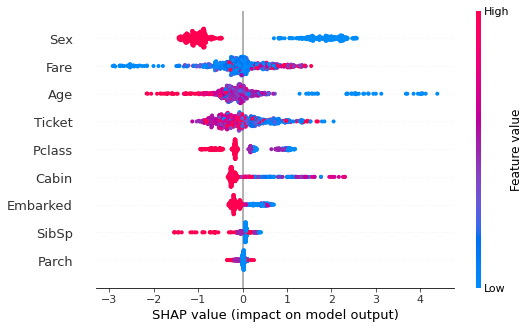

In [63]:
shap.summary_plot(main_shap_values, label_train)

**1. Sex: высокий shap value свидетельствует о высоком влиянии на предсказании модели, т.е. на вероятность выживания. В нашей кодировке значение 0 соответствует женщинам(на графике - голубой цвет), 1 - мужчинам(на графике - розовый цвет). По графику видно, что женщины выживали чаще, так как мужчины, рискуя своей жизнью, спасали женщин и детей в первую очередь**

**2. Fare: это цена, заплаченая за круиз. Выше цена => лучше условия => выше шанс выжить.**

**3. Age: чем ниже возраст, тем больше шанс выжить. Родители пытались спасать своих детей. А старые люди просто редко переживали те условия.**

**4. Ticket: не очень репрезентативный признак, возможно нужно сменить категориальный кодировщик**

**5. Pclass: лучший и самый дорогой класс - 1, средний - 2, эконом - 3. Та же ситуация, что и в Fare**

**6. Embarked: 3 = S = Southampton, 0 = C = Cherbourg, 2 = Q = Queenstown, 1 = NaN = пропущеное значение. Судя по графику, пассажиры из C имели выше шанс выжить. Вероятно, это какой-то элитный район**

**7. SibSp: количество родственников. Люди с большим их количеством имели ниже шанс выжить, так как спасали их, а не себя**

**8. Parch: количество родителей или детей. Вероятно, низкий шанс выжить имели многодетные родители, но, в то же время, дети с двумя родителями на борту имели высокий шанс на выживание. Этот признак можно было бы разделить на 2: по количеству родителей и детей**

In [71]:
print(label_encoded_train.Embarked.unique())
print(train.Embarked.unique())
print(label_encoded_train.Pclass.unique())
print(train.Pclass.unique())

[3 0 2 1]
['S' 'C' 'Q' nan]
[2 0 1]
[3 1 2]


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


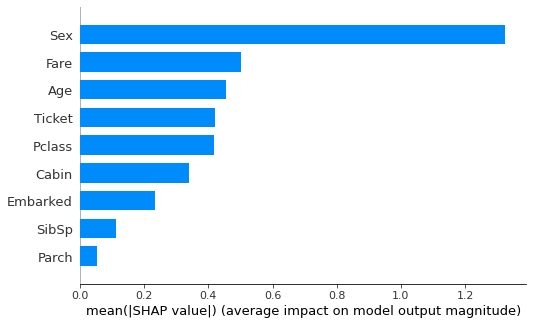

In [64]:
shap.summary_plot(main_shap_values, label_train, plot_type="bar", max_display=50)

**На этом графике видно, что наибольшее среднее влияние на предсказание имеет Sex. Далее признаки до Embarked оказывают среднее влияние. Признаки SibSp и Parch не очень влияют, при надобности их можно убрать**

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


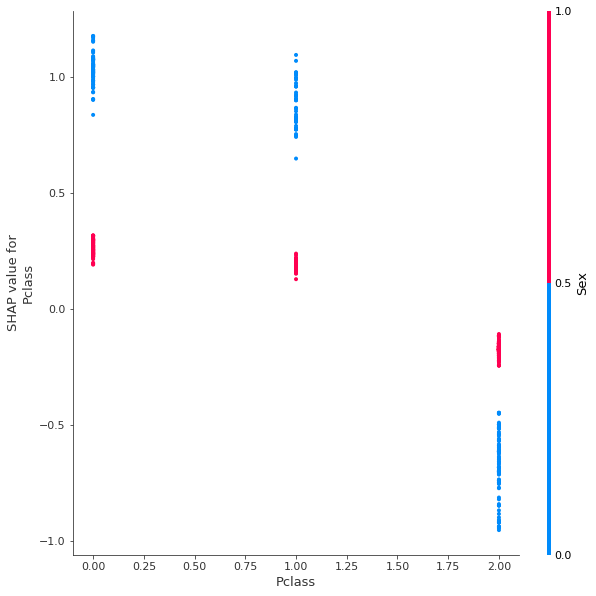

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


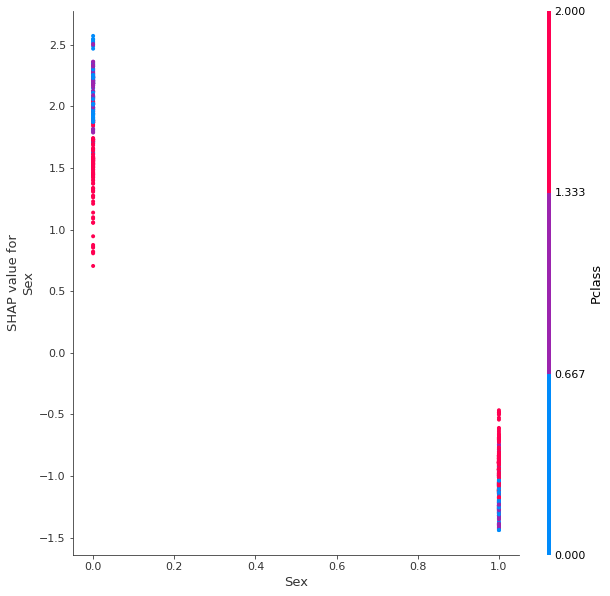

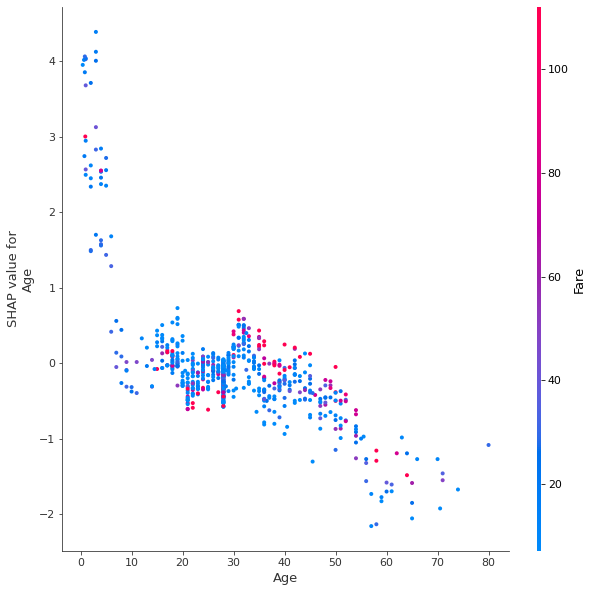

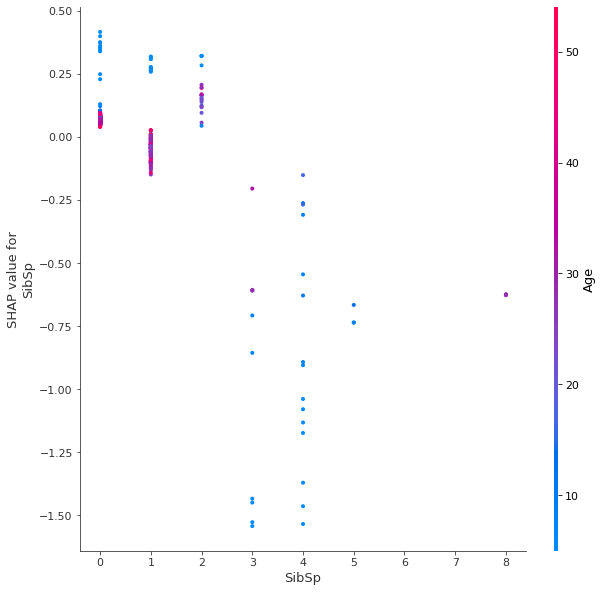

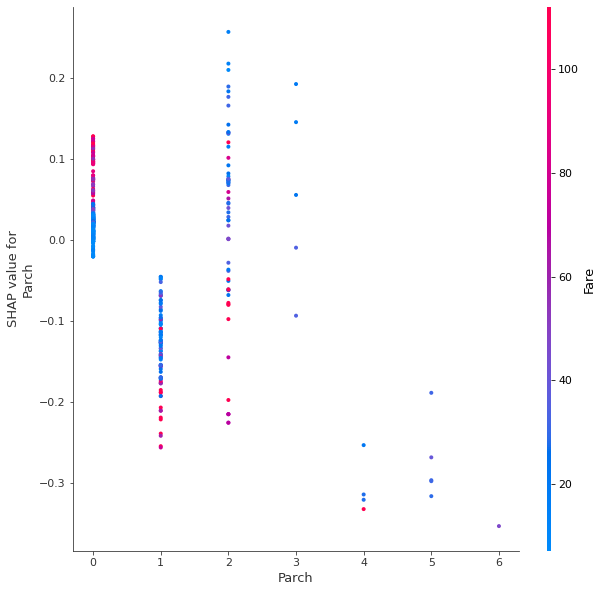

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


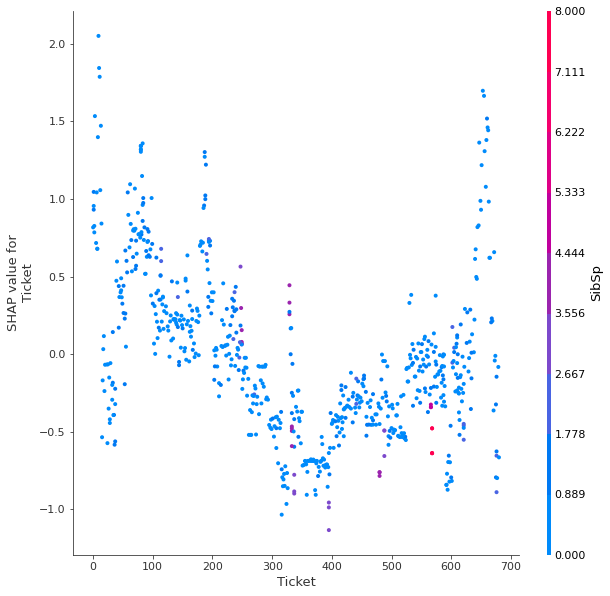

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


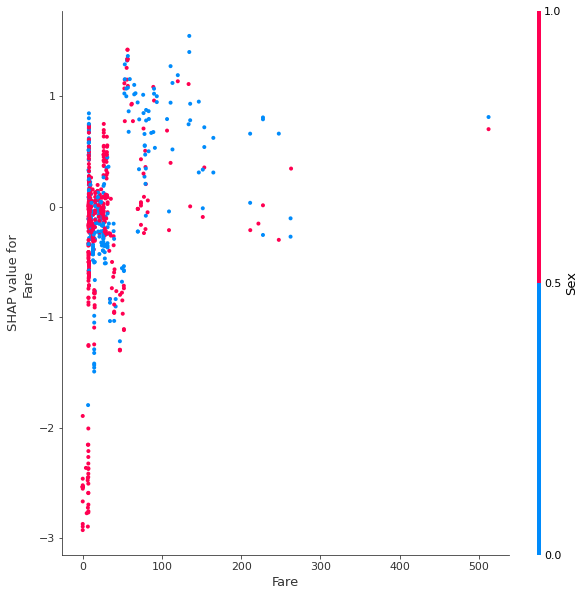

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


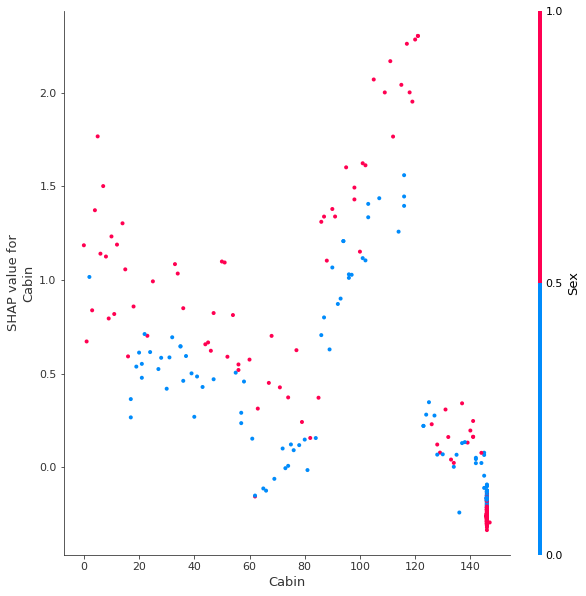

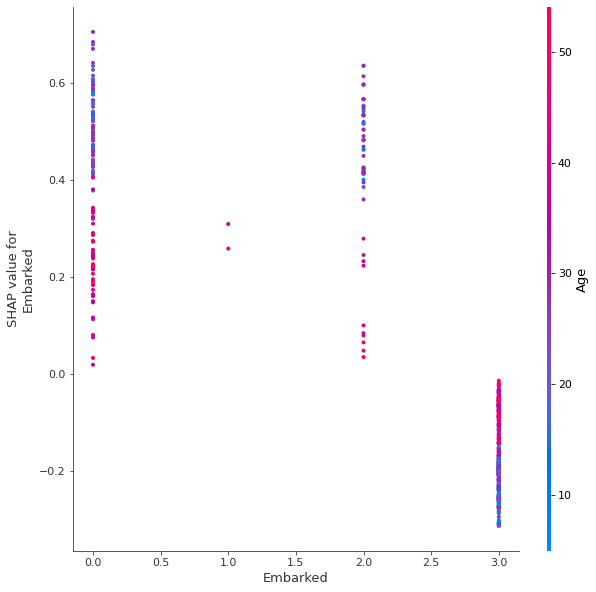

In [67]:
for name in label_train.columns:
    figsize = (10, 10)
    fig, ax = plt.subplots(figsize=figsize)
    shap.dependence_plot(name, main_shap_values, label_train, display_features=label_encoded_train, ax=ax)